# Tutoral: `pywrdrb.Data`

## Overview

There are multiple datasets that will be of interest when interacting with the `pywrdrb`, including:

- Pywr-DRB output data (`"output"`) : Results from `pywrdrb` simulations (e.g., streamflow at model nodes, reservoir storage, flow targets, etc.)
- Observation data (`"obs"`) : Measured USGS gauge streamflow and reservoir storage timeseries
- Hydrologic Model Data (`"nhmv10"`, `"nwmv21"`): Outputs from external hydrologic models like NWMv2.1 or NHMv1.0.

The `pywrdrb.Data` class is designed to provide easy methods for loading and accessing all of the datatypes.

## `pywrdrb.Data()` Functionality




### Arguments

The keyword arguments are:

- `output_dir` (str): Directory for output files.
- `input_dir` (str): Directory for input files.
- `datatypes` (list): List of data types to load. Options: 'output', 'obs', 'nhmv10', 'nwmv21' (default []).
- `results_sets` (list): List of results sets to load (default [])
- `output_filenames` (list): List of pywrdrb output filenames with path to load. Only necessary when `output` is in datatypes (default None).
- `units` (str): Units for the results. (default 'MG').
- `print_status` (bool): Whether to print status updates during load (default False).


Keyword arguments can be provided during either the initialization or the load methods. I.e.,

```python
data = pywrdrb.Data(**kwargs)
data.load()
```

or:

```python
data = pywrdrb.Data()
data.load(**kwargs)
```

#### A note on `results_sets`...


The `results_set` options are used to specify _what type of variables you are interested in_. For example, if you want to access the streamflow at major Pywr-DRB model nodes, then you want `results_sets = ['major_flow']`. Another example is `results_sets = ["res_storage"]` which returns reservoir storage timeseries. 

You can find descriptions of each `results_set` type in [`pywrdrb.utils.results_sets`](../pywrdrb/utils/results_sets.py).

Different `datatypes` have different valid `results_set` options. 

- `"output"` data can access all results_set options
- `"obs"` data can only access results_set in `['major_flow', 'reservoir_downstream_gage', 'res_storage']`
- `"nhmv10"` and `"nwmv21"` can only access results_set in `['major_flow', 'reservoir_downstream_gage']`


Fortunately, the `pywrdrb.Data` class will identify valid results_set options for each datatype, and only process those valid options. 


### Accessing Data

Given that there are multiple datasets of interest, the `pywrdrb.Data` class uses a hierarchical structure for storing this data within the `pywrdrb.Data` object. 

After using `pywrdrb.Data().load()`, results are stored in the class as a nested dictionary structure following:

```python
data = pywrdrb.Data()
data.load(**kwargs)

data.results_set[datatype_label][scenario_number] -> pd.DataFrame
```

#### A note on the `dataset` labeling...


In the `pywrdrb.Data` class, the `dataset_label` for `"output"` datatypes is derived from the output filenames. This label serves as a key in the final stored data, allowing users to identify and access results associated with custom `pywrdrb` simulations or scenarios.

For example, if you run a `pywrdrb` simulation and store the results in `output_file = "<path>/my_simulation.hdf5"`, then these simulation results can be accessed using:

```python
data = pywrdrb.Data()
data.load(
    datatypes = ['output'],
    output_filenames = [output_file],
    results_sets = ['major_flow']
    )

# Access custom output data
data.major_flow["my_simulation"][0]
```

In [1]:
# Set path to access pywrdrb
import sys
path_to_pywrdrb = '../'
sys.path.append(path_to_pywrdrb)


from pywrdrb import Data
from pywrdrb.utils.directories import output_dir

# List of datatypes to load
# Options: 'obs', 'output', 'nhmv10', 'nwmv21'
datatypes = ['output', 'obs', 'nhmv10']

# List of pywrdrb output files, with path
# NOTE: This is only necessary if 'output' is in datatypes
output_files = [
    rf"{output_dir}drb_output_nhmv10.hdf5",
]

# List of results sets to load 
# See pywrdrb.utils.results_sets for available results sets
results_sets = [
    'major_flow',
    'res_storage'
]


In [2]:
# Initialize Data object and load data
data = Data(print_status=True)

data.load(datatypes=datatypes, 
          output_filenames=output_files, 
          results_sets=results_sets
          )

# show an example of the major_flow results set for `drb_output_nhmv10` output file
data.major_flow['drb_output_nhmv10'][0].head(2)

Loading output data...
Loading major_flow data from drb_output_nhmv10
Loading res_storage data from drb_output_nhmv10
Loading obs data...
Loading major_flow data from observations
Loading res_storage data from observations
Loading nhmv10 data...
Loading major_flow data from nhmv10


,01417000,01425000,01433500,01436000,01447800,01449800,01463620,01470960,delDRCanal,delLordville,delMontague,delTrenton,outletAssunpink,outletSchuylkill
1983-10-01,245.248604,192.037241,702.126510,216.100859,1296.612713,30.641998,77.324137,981.138761,872.861166,626.737443,1050.155248,804.943656,110.874962,329.747828
1983-10-02,157.896171,150.911779,716.300505,60.483957,1298.492457,32.867673,77.732775,982.026219,1837.957440,514.753462,2386.712148,1772.532316,132.337899,688.332292


In [3]:
# check the datatype keys stored in the data object
list(data.major_flow.keys())

['drb_output_nhmv10', 'obs', 'nhmv10']

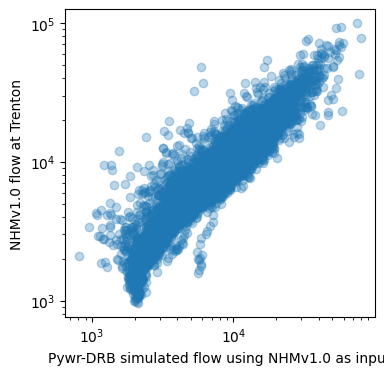

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.scatter(data.major_flow['drb_output_nhmv10'][0].loc[:, 'delTrenton'], 
            data.major_flow['nhmv10'][0].loc[:, 'delTrenton'], alpha=0.3)
plt.ylabel('NHMv1.0 flow at Trenton')
plt.xlabel('Pywr-DRB simulated flow using NHMv1.0 as input')
plt.yscale('log')
plt.xscale('log')
plt.show()

## Exporting custom datasets

Once a `pywrdrb.Data` object has been loaded and populated with data, then you can export the full contents of the `pywrdrb.Data` object to a custom HDF5 file.  This custom dataset can then be re-loaded later, without having to replicate the original `pywrdbr.Data.load()` workflow shown above. 

The code block below shows how the previously generated `data` object can be exported and re-loaded. 

In [5]:
# Custom dataset filename
custom_datafile = rf"{output_dir}custom_datset.hdf5"

# Export the data object to a custom dataset
data.export(custom_datafile)

# Make a new data object and load the custom dataset
data2 = Data(print_status=True)
data2.load_from_export(custom_datafile)


# Show that the data object contents are the same
data2.major_flow.keys() == data.major_flow.keys()
data2.major_flow['drb_output_nhmv10'][0].equals(data.major_flow['drb_output_nhmv10'][0])

c:\Users\tjame\Desktop\Research\DRB\Pywr-DRB\Pywr-DRB\win_venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


True

## Technical detail (To be completed...)

The `pywrdrb.Data` class relies on multiple different .

- `AbstractDataLoader`: The base class defining shared methods for parsing arguments, validating datasets, and handling attributes.
    - `Output(AbstractDataLoader)`: Loads Pywr-DRB simulation results.
    - `Observation(AbstractDataLoader)`: Loads observational data.
    - `HydrologicModelFlow(AbstractDataLoader)`: Loads hydrologic model outputs.
- `get_pywrdrb_results()`: Handles loading results from simulation output files; used in `Output(AbstractDataLoader)`.
- `get_base_results()`: Loads observation or hydrologic model data; used in `Observation` and` HydrologicModelFlow` classes.



## `Output` Class

The `Output` class consolidates this entire process into a single `load()` method, automatically validating inputs, handling scenarios, and storing results inside the Ouput `object`.

`Output.load()` uses `get_pywrdrb_results()` to fetch data for all specified `models` and `results_sets`. It manages datetime indexing and scenarios, and then stores the results as attributes within the class.


### pywrdrb.post.get_pywrdrb_results()

The `get_pywrdrb_results()` reads data from Pywr-DRB output files (`hdf5`) stored in the output directory and returns a dictionary of results along with a datetime index. 

This function is designed to handle different result types (`results_sets`), such as `"res_storage"`, `"major_flow"`, `"res_release"`, and more. This function makes it easy to extract specific variables, but it requires specifying each results_set separately and can be slow when constructing date indexes.

## `Observation` Class

TBC.

## `HydrologicModelFlow` Class

TBC.